## Flow chart for dirty zillow pipeline
This notebook contains code to create a flow chart of the dirty zillow pipeline and all preprocessing necessary to run both the clean zillow and dirty zillow experiment.

In [1]:
# Prerequisites: You need flowgiston and graphviz installed, on Mac OS X use e.g.
# !brew install graphviz
# !pip3 install flowgiston

### 1. Pipeline processing definitions

In [2]:
import csv
import pandas as pd
import re
from flowgiston import *

In [3]:
data_path = '../data/zillow_dirty.csv'

In [4]:
# helper row object to allow fancy integer and column based string access within UDFs!
class Row:
    def __init__(self, data, columns=None):
        assert(isinstance(data, (tuple, list)))
        assert(isinstance(columns, (tuple, list)) or columns is None)
        self.data = tuple(data)
        self.columns = tuple(columns[:len(data)]) if columns is not None else None 
        
    def __getitem__(self, key):
        # check for int also works for bool!
        if isinstance(key, int):
            return self.data[key]
        elif isinstance(key, str):
            if self.columns is None:
                raise KeyError("no columns defined, can't access column '{}'".format(key))
            elif key not in self.columns:
                raise KeyError("could not find column column '{}'".format(key))
            return self.data[self.columns.index(key)]
        else:
            raise IndexError()
            
    def __repr__(self):
        if self.columns:
            if len(self.columns) < len(self.data):
                self.columns = self.columns + [None] * (len(self.data) - len(self.columns))
            return '(' + ','.join(['{}={}'.format(c, d) for c, d in zip(self.columns, self.data)]) + ')'
        else:
            return '(' + ','.join(['{}'.format(d) for d in self.data]) + ')'
# recursive expansion of Row objects potentially present in data.
def expand_row(x):
    # Note: need to use here type construction, because isinstance fails for dict input when checking for list
    if hasattr(type(x), '__iter__') and not isinstance(x, str):
        if type(x) is tuple:
            return tuple([expand_row(el) for el in x])
        elif type(x) is list:
            return [expand_row(el) for el in x]
        elif type(x) is dict:
            return {expand_row(key) : expand_row(val) for key, val in x.items()}
        else:
            raise TypeError("custom sequence type used, can't convert to data representation")
    return x.data if isinstance(x, Row) else x

def result_to_row(res, columns=None):
    # convert result to row object, i.e. deal with unpacking etc.
    # is result a dict?
    if type(res) is dict:
        # are all keys strings? If so, then unpack!
        # else, keep it as dict return object!
        if all(map(lambda k: type(k) == str, res.keys())):
            # columns become keys, values 
            columns = res.keys()
            data = tuple(map(lambda k: res[k], columns))
            return Row(data, columns)
    
    
    # is it a row object?
    # => convert to tuple!
    r = expand_row(res)
    
    if type(r) is not tuple:
        r = (r,)
    else:
        if len(r) == 0:
            r ((),) # special case, empty tuple
    
    return Row(r, columns)

def apply_func(f, row):
    if len(row.data) != 1:
        return f(row)
    else:
        try:
            return f(row)
        except TypeError as te:
            msg = str(te)
            # single op error?
            # try unwrapped...
            return f(row.data[0])

In [5]:
# pure python class to create dataflow!

class Dataset:
    
    def __init__(self):
        self.es = []
        self.ns = []
        self.name = None
        self.parent = None
    
    @classmethod
    def from_csv(cls, path):
        # special conversion function for boolean necessary
        def to_bool(value):
            valid = {'true':True, 't':True, 'yes':True, 'y':True, 'false':False, 'f':False, 'no':False, 'n':False,              }   
        
            if isinstance(value, bool):
                return value
        
            if not isinstance(value, str):
                raise ValueError('invalid literal for boolean. Not a string.')
        
            lower_value = value.lower()
            if lower_value in valid:
                return valid[lower_value]
            else:
                raise ValueError('invalid literal for boolean: "%s"' % value)
        
        def parse(s):
            assert isinstance(s, str)
            # try to parse s as different types
            if s in ['',]:
                return None
            try:
                return to_bool(s)
            except:
                pass
            try:
                return int(s.strip())
            except:
                pass
            try:
                return float(s.strip())
            except:
                pass
            try:
                return json.loads(s.strip())
            except:
                pass
            # return as string, final option remaining...
            return s
        
        ds = cls()
        ds.name = "readcsv"
        
        with open(data_path, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for i, csv_row in enumerate(reader):
                parsed_row = [parse(el) for el in csv_row.values()]
                row = Row(parsed_row + [i], list(csv_row.keys()) + ['row_number'])
                ds.ns.append(row)
        return ds
    
    def withColumn(self, column, ftor):
        ds = Dataset()
        ds.parent = self
        ds.name = 'withColumn'
        ds.column = column
        
        for row in self.ns.copy():
            # go over all rows and process into normal set or exception set!
            try:
                call_res = apply_func(ftor, row)
                if column in row.columns:
                    col_idx = row.columns.index(column)
                    tmp = list(row.data)
                    tmp[col_idx] = expand_row(call_res)
                    row.data = tuple(tmp)
                else:
                    row.columns = row.columns + (column,) if row.columns is not None else tuple([None] * len(row.data), column)
                    row.data = row.data + result_to_row(call_res).data
                    
                ds.ns.append(row)
            except Exception as e:
                entry = {'exception': e, 'ename' : type(e).__name__, 'row': row}
                ds.es.append(entry)
        
        return ds
    
    def filter(self, ftor):
        ds = Dataset()
        ds.parent = self
        ds.name = 'filter'
        for row in self.ns.copy():
            try:
                call_res = apply_func(ftor, row)
                if call_res:
                    ds.ns.append(row)
            except Exception as e:
                entry = {'exception': e, 'ename' : type(e).__name__, 'row': row}
                ds.es.append(entry)
        return ds
    
    def mapColumn(self, column, ftor):
        ds = Dataset()
        ds.parent = self
        ds.name = 'mapColumn'
        ds.column = column
        
        for row in self.ns.copy():
            try:
                col_idx = row.columns.index(column)
                arg = row.data[col_idx]
                call_res = f(arg)
                tmp = list(row.data)
                tmp[col_idx] = expand_row(call_res)
                row.data = tuple(tmp)

                ds.ns.append(row)
            except Exception as e:
                entry = {'exception': e, 'ename' : type(e).__name__, 'row': row}
                ds.es.append(entry)
        return ds
    
    def ignore(self, exception):
        ds = Dataset()
        ds.parent = self
        ds.ns = self.ns.copy()
        ds.name = 'ignore'
        
        ds.es = list(filter(lambda x: exception.__name__ != x['ename'], self.es))
        
        ds.ignored = len(self.es) - len(ds.es)
        
        return ds
    
    def resolve(self, exception, ftor):
        ds = Dataset()
        ds.parent = self
        ds.ns = self.ns.copy()
        ds.name = 'resolve'
        
        dummy_ds = Dataset()
        dummy_ds.ns = []
        
        for entry in self.es:
            if exception.__name__ == entry['ename']:
                dummy_ds.ns.append(entry['row'])
            else:
                ds.es.append(entry)
                
        # call on dummy ds same operation using ftor!
        p = self
        while p is not None and p.name == 'resolve' or p.name == 'ignore':
            p = p.parent
        normal_name = p.name
        res_ds = None
        if normal_name == 'withColumn':
            res_ds = dummy_ds.withColumn(p.column, ftor)
        elif normal_name == 'mapColumn':
            res_ds = dummy_ds.mapColumn(p.column, ftor)
        else:
            raise Exception('op {} not supported yet!'.format(normal_name))
            
        ds.num_resolved = len(res_ds.ns)
        ds.num_throwing = len(res_ds.es)
            
        ds.ns += res_ds.ns
        ds.es += res_ds.es
                
        return ds
    
    def selectColumns(self, columns):
        ds = Dataset()
        ds.parent = self
        ds.name = 'selectColumns'
        
        for row in self.ns:
            proj_row = Row(tuple([row[name] for name in columns]), columns.copy())
            ds.ns.append(proj_row)
        
        return ds
        
    # left to implement: resolve, ignore, filter, mapColumn, selectColumns.
    # + charting!

In [6]:
import math
import re

def extractBd(x):
    val = x['facts and features']
    max_idx = val.find(' bd')
    if max_idx < 0:
        max_idx = len(val)
    s = val[:max_idx]

    # find comma before
    split_idx = s.rfind(',')
    if split_idx < 0:
        split_idx = 0
    else:
        split_idx += 2
    r = s[split_idx:]
    return int(r)

def resolveBd(x):
    if 'Studio' in x['facts and features']:
        return 1
    raise ValueError
    
def extractType(x):
    t = x['title'].lower()
    type = 'unknown'
    if 'condo' in t or 'apartment' in t:
        type = 'condo'
    if 'house' in t:
        type = 'house'
    return type

def extractBa(x):
    val = x['facts and features']
    max_idx = val.find(' ba')
    if max_idx < 0:
        max_idx = len(val)
    s = val[:max_idx]

    # find comma before
    split_idx = s.rfind(',')
    if split_idx < 0:
        split_idx = 0
    else:
        split_idx += 2
    r = s[split_idx:]
    ba = math.ceil(2.0 * float(r)) / 2.0
    return ba

def extractSqft(x):
    val = x['facts and features']
    max_idx = val.find(' sqft')
    if max_idx < 0:
        max_idx = len(val)
    s = val[:max_idx]

    split_idx = s.rfind('ba ,')
    if split_idx < 0:
        split_idx = 0
    else:
        split_idx += 5
    r = s[split_idx:]
    r = r.replace(',', '')
    return int(r)

def extractOffer(x):
    offer = x['title'].lower()
    if 'sale' in offer:
        return 'sale'
    if 'rent' in offer:
        return 'rent'
    if 'sold' in offer:
        return 'sold'
    if 'foreclose' in offer.lower():
        return 'foreclosed'
    return offer

def extractPrice(x):
    price = x['price']
    p = 0
    if x['offer'] == 'sold':
        # price is to be calculated using price/sqft * sqft
        val = x['facts and features']
        s = val[val.find('Price/sqft:') + len('Price/sqft:') + 1:]
        r = s[s.find('$')+1:s.find(', ') - 1]
        price_per_sqft = int(r)
        p = price_per_sqft * x['sqft']
    elif x['offer'] == 'rent':
        max_idx = price.rfind('/')
        p = int(price[1:max_idx].replace(',', ''))
    else:
        # take price from price column
        p = int(price[1:].replace(',', ''))

    return p

In [7]:
def zillow_pipeline(data_path, exclude_resolvers=False):
    """ process updated zillow pipeline yielding condos for sale """
    ds = [Dataset.from_csv(data_path)]
    ds.append(ds[-1].withColumn('bedrooms', extractBd))
    if not exclude_resolvers:
        ds.append(ds[-1].resolve(ValueError, resolveBd))
        ds.append(ds[-1].ignore(ValueError))
    ds.append(ds[-1].filter(lambda x: x['bedrooms'] < 10))
    ds.append(ds[-1].withColumn("type", extractType))
    ds.append(ds[-1].filter(lambda x: x['type'] == 'condo'))
    ds.append(ds[-1].withColumn("zipcode", lambda x: '%05d' % int(x['postal_code'])))
    if not exclude_resolvers:
        ds.append(ds[-1].ignore(TypeError))
    ds.append(ds[-1].withColumn("bathrooms", extractBa))
    if not exclude_resolvers:
        ds.append(ds[-1].ignore(ValueError))
    ds.append(ds[-1].withColumn("sqft", extractSqft))
    ds.append(ds[-1].ignore(ValueError))
    ds.append(ds[-1].withColumn("offer", extractOffer))
    ds.append(ds[-1].withColumn("price", extractPrice))
    if not exclude_resolvers:
        ds.append(ds[-1].resolve(ValueError, lambda x: int(re.sub('[^0-9.]*', '', x['price']))))
    ds.append(ds[-1].filter(lambda x: 100000 < x['price'] < 2e7 and x['offer'] == 'sale'))
    ds.append(ds[-1].selectColumns(["url", "zipcode", "address", "city", "state",
                             "bedrooms", "bathrooms", "sqft", "offer", "type", "price"]))
    return ds

## 2. Create flow chart for original dataset

In [8]:
# process to get indices & graph
data_path = '../data/zillow_dirty.csv'
steps = zillow_pipeline(data_path)
output_indices = set(map(lambda x: x['row_number'], steps[-2].ns))

Example errors happening in the dirty zillow pipeline:

In [9]:
for step in steps:
    if len(step.es) > 0:
        print(step.es[0]['row'])

(title=For Rent,address=None,city=None,state=None,postal_code=None,price=None,facts and features=1 $1,500+,real estate provider=None,url=https://www.zillow.com/b/35-Prospect-St-WOBURN-MA/42.477146,-71.148444_ll/,sales_date=Updated today,row_number=48)
(title=For Rent,address=None,city=None,state=None,postal_code=None,price=None,facts and features=1 $1,500+,real estate provider=None,url=https://www.zillow.com/b/35-Prospect-St-WOBURN-MA/42.477146,-71.148444_ll/,sales_date=Updated today,row_number=48)
(title=One Canal Apartment Homes,address=None,city=None,state=None,postal_code=None,price=None,facts and features=0 $2,605 2 $7,295 3 $7,009,real estate provider=None,url=https://www.zillow.com/b/one-canal-apartment-homes-boston-ma-5Xj76y/,sales_date=Updated yesterday,row_number=3797,bedrooms=9,type=condo)
(title=Apartment For Rent,address=19 Chestnut St APT 3B,city=Boston,state=MA,postal_code=2108.0,price=$2,750/mo,facts and features=1 bd , -- ba , 625 sqft,real estate provider=None,url=htt

Overall flow of exceptions/normal rows printed as flow chart

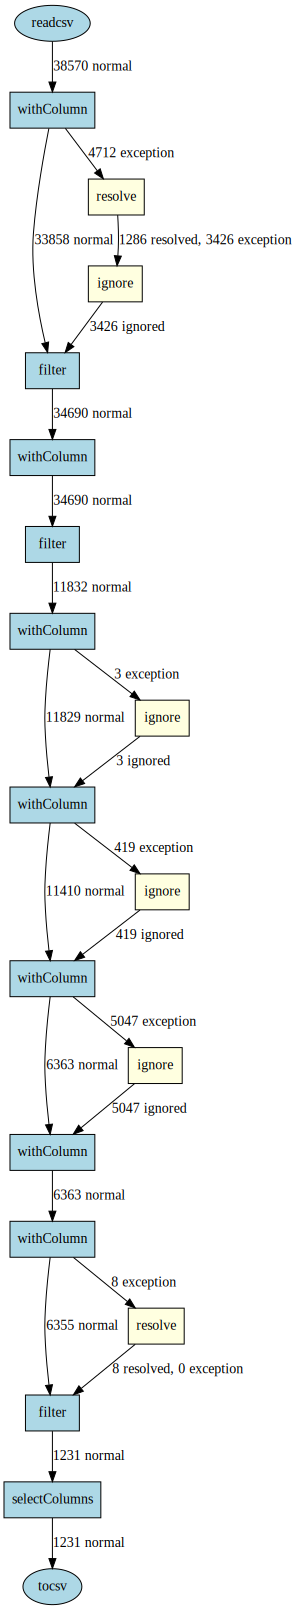

In [10]:
# create flow graph
node = steps[-1]

def make_chart(node):
    Base = flowgiston_base(fillcolor='lightblue')

    class OpNode(Base):
        style='filled'
        shape='box'

    class ExceptNode(Base):
        style='filled'
        shape='box'
        fillcolor = 'lightyellow'

    chart = FlowgistonChart(Base)
    last_node = chart.end('tocsv')

    last_except_path_node = None
    while node is not None:
        if node.name != 'resolve' and node.name != 'ignore':
            new_last_node = chart.OpNode.node(node.name) if node.parent else chart.start(node.name)
            new_last_node.edge(last_node, ' {} normal'.format(len(node.ns))) # how many inflowing from ns of parent?
            last_node = new_last_node

            if last_except_path_node is not None:
                new_last_node.edge(last_except_path_node, ' {} exception'.format(len(node.es)))
                last_except_path_node = None
            node = node.parent
        else:

            # go except chain up!
            except_node = last_node
            while node is not None and node.name == 'resolve' or node.name == 'ignore':
                next_except_node = chart.ExceptNode.node(node.name)
                edge_label = ''

                if node.name == 'resolve':
                    edge_label = '  {} resolved, {} exception'.format(node.num_resolved, node.num_throwing)
                elif node.name == 'ignore':
                    edge_label ='  {} ignored'.format(node.ignored)
                next_except_node.edge(except_node, edge_label)
                except_node = next_except_node
                last_except_path_node = except_node
                node = node.parent
    return chart

chart = make_chart(node)
chart

In [11]:
# render file to pdf
chart.render('zillow_dirty_flow_graph')

'zillow_dirty_flow_graph.pdf'

### 3. Obtain row numbers for normal rows and bad rows

In [12]:
data_path = '../data/zillow_dirty.csv'
steps = zillow_pipeline(data_path, exclude_resolvers=True)

In [13]:
normal_indices = set(map(lambda r: r['row_number'], steps[0].ns))
except_indices = set()
for step in steps:
    if len(step.ns) > 0 and 'row_number' in step.ns[0].columns:
        normal_indices = normal_indices & set(map(lambda r: r['row_number'], step.ns))
        except_indices |= set(map(lambda e: e['row']['row_number'], step.es))

There should be 9635 except indices:

In [14]:
len(except_indices)

9635

and 1211 normal rows as final output

In [15]:
len(normal_indices)

1211

In order to generate synthetic file, let's save indices to file in sorted order:

In [16]:
df = pd.DataFrame(sorted(except_indices), columns=['bad_indices'])
df.to_csv('../data/exception_rows_indices.csv', index=None)

From the above pipeline, we see that there are two operators using resolve functions. Which rows do they resolve?
We use these rows to replace original bad rows in the file for the synthetic generation.

In [17]:
steps = zillow_pipeline(data_path)

In [18]:
except_resolved_indices = set()
for step in steps:
    if step.name == 'resolve':
        parent_es_indices = set(map(lambda e: e['row']['row_number'], step.parent.es))
        es_indices = set(map(lambda e: e['row']['row_number'], step.es))
        
        # which es indices did resolve actually resolve?
        resolved_indices = parent_es_indices - es_indices
        print('resolver resolved {}'.format(len(resolved_indices)))
        print(step.parent.name, len(step.parent.es))
        print(step.name, len(step.es))
        except_resolved_indices |= resolved_indices

resolver resolved 1286
withColumn 4712
resolve 3426
resolver resolved 8
withColumn 8
resolve 0


In [19]:
len(except_resolved_indices)

1294

To avoid the averaging out effect, let's only use rows which make it to the final output.

In [20]:
output_indices = list(map(lambda r: r['row_number'], steps[-2].ns))
len(output_indices)

1231

In [21]:
except_resolved_indices = list(set(output_indices) & set(except_resolved_indices))
len(except_resolved_indices)

20

Write indices to file as well

In [22]:
df = pd.DataFrame(sorted(except_resolved_indices), columns=['resolved_indices'])
df.to_csv('../data/exception_rows_resolved_indices.csv', index=None)

### 4. Checking whether synthetic data and clean data are correctly working
#### 4.1 synthetic data

In [23]:
!cd .. && python3 preprocess-data.py -s 1 -m synth -o data/zillow_synthetic.csv

>>> reading input files
>>> substituting lines
>>> replicating data 1x
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]
done.


In [24]:
data_path = '../data/zillow_synthetic.csv'

In [25]:
steps = zillow_pipeline(data_path)

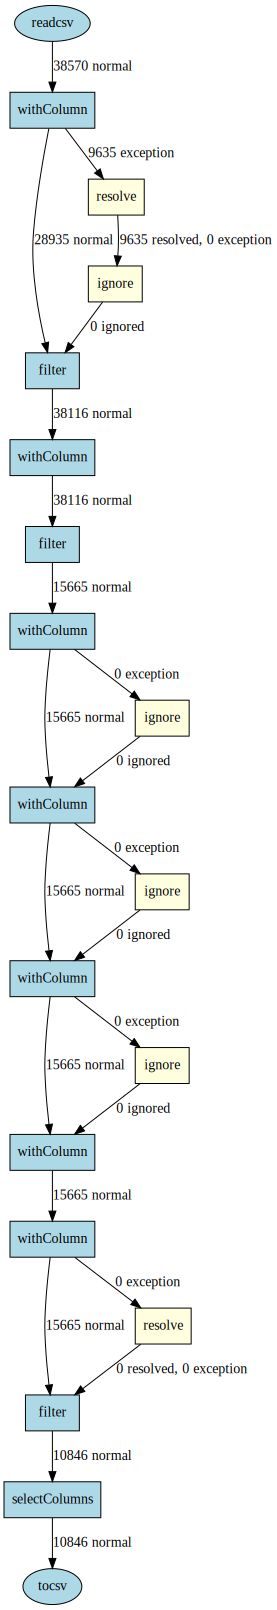

In [26]:
make_chart(steps[-1])

#### 4.2 clean data (no exceptions, no ignores, no resolves should happen)

In [27]:
!cd .. && python3 preprocess-data.py -s 1 -m clean -o data/zillow_clean.csv

>>> reading input files
>>> remove rows causing exceptions
>>> replicating data 1x
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]
done.


In [28]:
data_path = '../data/zillow_clean.csv'

In [29]:
steps = zillow_pipeline(data_path)

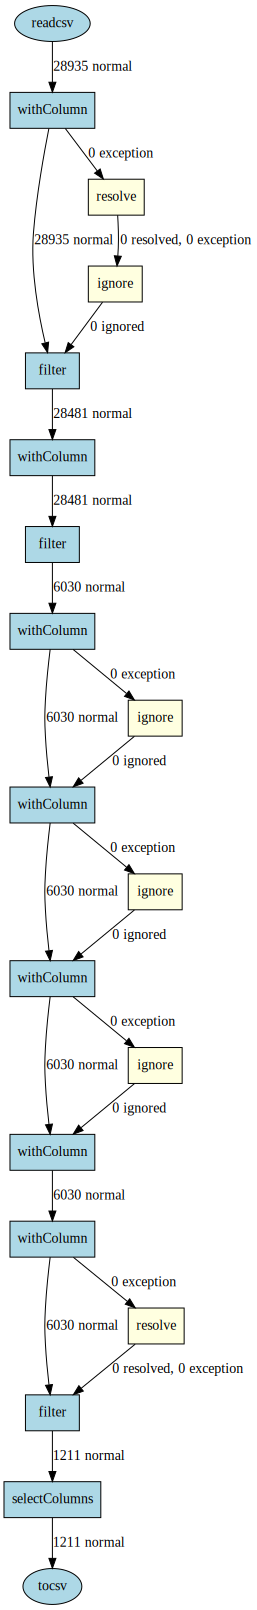

In [30]:
make_chart(steps[-1])